# Loading data

In [14]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [15]:
# paths for the dataset folders and label files
dataset1_path = 'APS360_Project_Dataset/dataset1/bank_card_images_train'
train_labels_path = 'APS360_Project_Dataset/dataset1/bank_card_images_train_labels.csv'

# Load the label CSV files
dataset1_card_labels = pd.read_csv(train_labels_path)
dataset1_card_labels = dataset1_card_labels[['index', 'card_num']]

print(dataset1_card_labels.head())

def load_images_from_dataset1(base_path, labels_df):
    images = []
    labels = []
    
    labels_df['index'] = labels_df['index'].astype(str)
    
    for index, row in labels_df.iterrows():
        img_file = os.path.join(base_path, row['index'])
        image = cv2.imread(img_file)
        
        if image is not None:
            images.append(image)
            labels.append(row['card_num'])  # card_num is the label
        else:
            print(f"Warning: Failed to load image {img_file}")
    
    return images, labels 

dataset1_images, dataset1_labels = load_images_from_dataset1(dataset1_path, dataset1_card_labels)

print(f"Loaded {len(dataset1_images)} images from dataset1.")
print(f"First few labels: {dataset1_labels[:5]}")


   index    card_num
0  0.jpg  62257583.0
1  1.jpg  62257583.0
2  2.jpg  62257583.0
3  3.jpg  62257583.0
4  4.jpg  62257583.0


KeyboardInterrupt: 

In [ ]:
# for yolo object detection
dataset2_images_path = 'APS360_Project_Dataset/dataset2/JPEGImages'
dataset2_annotations_path = 'APS360_Project_Dataset/dataset2/Annotations'

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    objects = []
    
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        objects.append({
            'bbox': [xmin, ymin, xmax, ymax]
        })
    
    return filename, objects

def load_images_for_dataset2(image_folder, annotation_folder):
    images = []
    annotations = []
    
    for xml_file in os.listdir(annotation_folder):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotation_folder, xml_file)
            filename, objects = parse_annotation(xml_path)
            img_path = os.path.join(image_folder, filename)
            image = cv2.imread(img_path)
            
            if image is not None:
                images.append(image)
                annotations.append(objects)
            else:
                print(f"Warning: Failed to load image {img_path}")
    
    return images, annotations

dataset2_images, dataset2_annotations = load_images_for_dataset2(dataset2_images_path, dataset2_annotations_path)

# Print the number of images and annotations loaded
print(f"Loaded {len(dataset2_images)} images and their corresponding annotations.")
print(f"First few annotations: {dataset2_annotations[:5]}")

Loaded 2161 images and their corresponding annotations.
First few annotations: [[{'bbox': [58, 140, 335, 168]}], [{'bbox': [76, 192, 498, 228]}], [{'bbox': [24, 76, 192, 91]}], [{'bbox': [129, 244, 513, 279]}], [{'bbox': [125, 372, 870, 448]}]]


In [ ]:
# for yolo object detection
dataset3_path = 'APS360_Project_Dataset/dataset3_preprocessed'

In [ ]:
dataset4_path = 'APS360_Project_Dataset/dataset4'

def load_images_for_dataset4(base_path):
    images = []
    labels = []
    
    for label in os.listdir(base_path):
        folder_path = os.path.join(base_path, label)
        
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                image = cv2.imread(img_path)
                
                if image is not None:
                    images.append(image) 
                    labels.append(int(label))  # Folder name is the label (0-9)
                else:
                    print(f"Warning: Failed to load image {img_path}")
    
    return images, labels

dataset4_images, dataset4_labels = load_images_for_dataset4(dataset4_path)

print(f"Loaded {len(dataset4_images)} images from dataset4.")
print(f"First few labels: {dataset4_labels[:5]}")

Loaded 1136 images from dataset4.
First few labels: [0, 0, 0, 0, 0]


# Data Preprocessing

In [ ]:
# resize, convert to grey scale, normalize
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype('float32') / 255.0
    
    return image

In [ ]:
def preprocess_images(images):
    preprocessed_images = [preprocess_image(img) for img in images]
    return np.array(preprocessed_images)
preprocessed_dataset1_images = preprocess_images(dataset1_images)
preprocessed_dataset4_images = preprocess_images(dataset4_images)

In [ ]:
def preprocess_images_and_adjust_bboxes(images, annotations):
    preprocessed_images = []
    preprocessed_annotations = []
    
    for i, img in enumerate(images):
        original_height, original_width = img.shape[:2]
        img_preprocessed = preprocess_image(img)
        
        # Adjust bounding boxes for new image size
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        
        adjusted_bboxes = []
        for obj in annotations[i]:
            bbox = obj['bbox']
            adjusted_bbox = [
                int(bbox[0] * scale_x),
                int(bbox[1] * scale_y),
                int(bbox[2] * scale_x),
                int(bbox[3] * scale_y)
            ]
            adjusted_bboxes.append({'bbox': adjusted_bbox})
        
        preprocessed_images.append(img_preprocessed)
        preprocessed_annotations.append(adjusted_bboxes)
    
    return np.array(preprocessed_images), preprocessed_annotations

preprocessed_dataset2_images, preprocessed_dataset2_annotations = preprocess_images_and_adjust_bboxes(dataset2_images, dataset2_annotations)

# Data Augmentation

In [ ]:
import torch
import torchvision.transforms as transforms
import random
from PIL import Image

def augment_images(images, labels, target_count):
    augment_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(size=(224,224), scale=(0.9, 1.1)),
        transforms.ToTensor()
    ])
    
    augmented_images = []
    augmented_labels = []
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique_labels, counts))
    
    for label in unique_labels:
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        current_count = label_counts[label]
        required_count = target_count.get(label, current_count)
        
        if current_count < required_count:
            images_to_augment = random.choices(label_images, k=required_count - current_count)
            for img in images_to_augment:
                img_pil = Image.fromarray(img)  
                augmented_img = augment_transform(img_pil)
                aug_img_np = np.array(augmented_img.permute(1, 2, 0)) 
                aug_img_np = cv2.resize(aug_img_np, (224,224))  
                augmented_images.append(aug_img_np)
                augmented_labels.append(label)
    
    return augmented_images, augmented_labels

In [ ]:
target_count = {
    0: 300,
    1: 300,
    2: 300,
    3: 300,
    4: 300,
    5: 300,
    6: 300,
    7: 300,
    8: 300,
    9: 300
}

augmented_images, augmented_labels = augment_images(preprocessed_dataset4_images, dataset4_labels, target_count)

balanced_dataset4_images = np.concatenate((preprocessed_dataset4_images, augmented_images), axis=0)
balanced_dataset4_labels = np.concatenate((dataset4_labels, augmented_labels), axis=0)

print(f"Original dataset size: {len(dataset4_labels)}")
print(f"New dataset size after augmentation: {len(balanced_dataset4_labels)}")

Original dataset size: 1136
New dataset size after augmentation: 3000


In [ ]:
import os
import cv2
from collections import defaultdict

def save_images_to_labeled_folders(images, labels, base_dir="dataset4_preprocessed_augmented"):
    label_indices = defaultdict(int)
    
    for image, label in zip(images, labels):
        # Define the directory for the current label (e.g., "dataset4_preprocessed_augmented/0")
        label_dir = os.path.join(base_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)
        index = label_indices[label]
        filename = f"{label}_{index}.png"
        file_path = os.path.join(label_dir, filename)
        if image.dtype == 'float32':
            image = (image * 255).astype('uint8')
        
        cv2.imwrite(file_path, image)
        print(f"Saved: {file_path}")
        label_indices[label] += 1
    
save_images_to_labeled_folders(balanced_dataset4_images, balanced_dataset4_labels, base_dir="dataset4_preprocessed_augmented")

Saved: dataset4_preprocessed_augmented\0\0_0.png
Saved: dataset4_preprocessed_augmented\0\0_1.png
Saved: dataset4_preprocessed_augmented\0\0_2.png
Saved: dataset4_preprocessed_augmented\0\0_3.png
Saved: dataset4_preprocessed_augmented\0\0_4.png
Saved: dataset4_preprocessed_augmented\0\0_5.png
Saved: dataset4_preprocessed_augmented\0\0_6.png
Saved: dataset4_preprocessed_augmented\0\0_7.png
Saved: dataset4_preprocessed_augmented\0\0_8.png
Saved: dataset4_preprocessed_augmented\0\0_9.png
Saved: dataset4_preprocessed_augmented\0\0_10.png
Saved: dataset4_preprocessed_augmented\0\0_11.png
Saved: dataset4_preprocessed_augmented\0\0_12.png
Saved: dataset4_preprocessed_augmented\0\0_13.png
Saved: dataset4_preprocessed_augmented\0\0_14.png
Saved: dataset4_preprocessed_augmented\0\0_15.png
Saved: dataset4_preprocessed_augmented\0\0_16.png
Saved: dataset4_preprocessed_augmented\0\0_17.png
Saved: dataset4_preprocessed_augmented\0\0_18.png
Saved: dataset4_preprocessed_augmented\0\0_19.png
Saved: dat

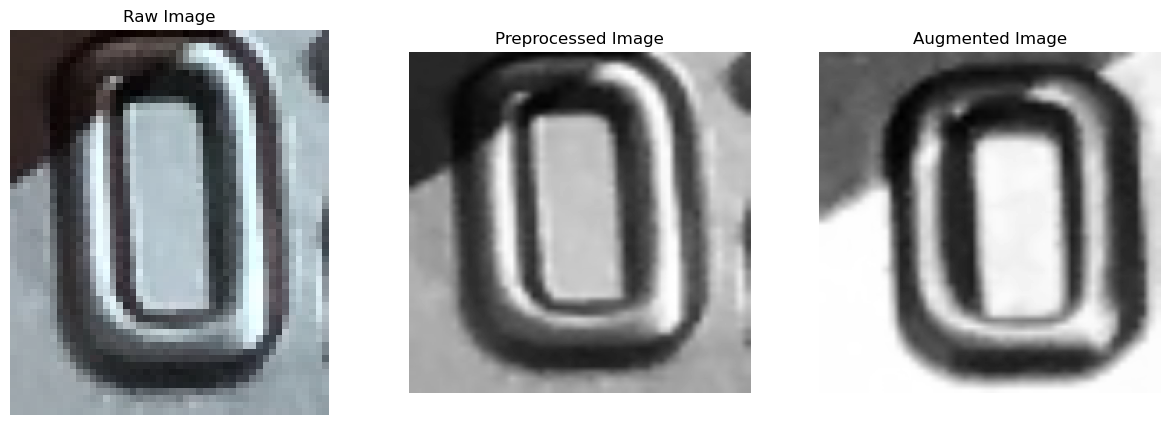

In [ ]:
raw_image = cv2.imread("APS360_Project_Dataset/dataset4/0/0_14.png", cv2.IMREAD_COLOR)
processed_image = cv2.imread("APS360_Project_Dataset/dataset4_preprocessed_augmented/0/0_11.png", cv2.IMREAD_GRAYSCALE)
augmented_image = cv2.imread("APS360_Project_Dataset/dataset4_preprocessed_augmented/0/0_94.png", cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(raw_image, cmap='gray')
ax[0].set_title("Raw Image")
ax[0].axis('off')
ax[1].imshow(processed_image, cmap='gray')
ax[1].set_title("Preprocessed Image")
ax[1].axis('off')
ax[2].imshow(augmented_image, cmap='gray')
ax[2].set_title("Augmented Image")
ax[2].axis('off')

plt.show()

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import torchvision.transforms as transforms


def augment_images_with_labels(image_folder, label_file, target_folder, augmented_label_file, target_count_per_image):
    # Ensure target folders exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    # Load labels
    labels_df = pd.read_excel(label_file)
    
    # Create a new DataFrame for augmented labels
    augmented_labels = pd.DataFrame(columns=labels_df.columns)
    
    # Counter for saving images sequentially
    image_counter = 1
    
    # Process each image
    for index, row in labels_df.iterrows():
        image_name = row['image_num']  # Assuming the column containing image names is called 'image_num'
        image_label = row['card_num']  # Assuming the column containing labels is called 'card_num'
        
        image_path = os.path.join(image_folder, f"{image_name}.jpg")
        
        try:
            original_image = Image.open(image_path).convert('RGB')  # Open and ensure RGB format
        except Exception as e:
            print(f"Error reading {image_path}: {e}")
            continue
        
        # Get image dimensions
        width, height = original_image.size
        
        # Save the original image and label
        original_save_path = os.path.join(target_folder, f"{image_counter}.jpg")
        original_image.save(original_save_path)
        augmented_labels = pd.concat([augmented_labels, pd.DataFrame({'image_num': [image_counter], 'card_num': [image_label]})], ignore_index=True)
        image_counter += 1  # Increment counter
        
        # Generate augmented images and labels
        for i in range(target_count_per_image):
            # Augmentation transform
            augment_transform = transforms.Compose([
                transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Slight translation
                transforms.RandomResizedCrop(size=(height, width), scale=(0.9, 1.0)),  # Small crop, same size
                transforms.ToTensor()
            ])
            
            augmented_image = augment_transform(original_image)  # Apply transformations
            
            # Convert tensor to NumPy array
            aug_image_np = np.array(augmented_image.permute(1, 2, 0) * 255, dtype=np.uint8)  # Convert to NumPy
            
            # Convert to BGR for OpenCV compatibility
            aug_image_np = cv2.cvtColor(aug_image_np, cv2.COLOR_RGB2BGR)
            
            # Save augmented image sequentially
            augmented_save_path = os.path.join(target_folder, f"{image_counter}.jpg")
            
            try:
                cv2.imwrite(augmented_save_path, aug_image_np)
                # Save corresponding label for augmented image
                augmented_labels = pd.concat(
                    [augmented_labels, pd.DataFrame({'image_num': [image_counter], 'card_num': [image_label]})],
                    ignore_index=True
                )
                image_counter += 1  # Increment counter
            except Exception as e:
                print(f"Error saving {augmented_save_path}: {e}")
    
    # Save augmented labels to Excel
    augmented_labels.to_excel(augmented_label_file, index=False)
    print(f"Augmented images and labels saved to {target_folder} and {augmented_label_file}.")


# Paths
image_folder = "APS360_Project_Dataset/dataset5/img"  # Path to the folder containing images
label_file = "APS360_Project_Dataset/dataset5/labels.xlsx"  # Path to the label file
target_folder = "APS360_Project_Dataset/dataset5_augmented/img"  # Path to save augmented images
augmented_label_file = "APS360_Project_Dataset/dataset5_augmented/labels_augmented.xlsx"  # Path to save augmented labels
target_count_per_image = 3  # Number of augmented images per original image

# Call the function
augment_images_with_labels(image_folder, label_file, target_folder, augmented_label_file, target_count_per_image)


c:\Users\Lione\miniconda3\envs\APS360\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Augmented images and labels saved to APS360_Project_Dataset/dataset5_augmented/img and APS360_Project_Dataset/dataset5_augmented/labels_augmented.xlsx.
